In [377]:
import os
import gc
import random

import numpy as np
from PIL import Image
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import img_as_float
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.optimizers import adam
from keras.utils import conv_utils
from keras.engine.topology import Layer
from keras.datasets import mnist, cifar10
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, PReLU, BatchNormalization, Add, LeakyReLU, Dense, Flatten

In [171]:
path_data = '/home/ubuntu/COMP6208-AutoEncoder/several27/data/'
path_open_images_560_420 = path_data + 'open_images_560_420/'
path_open_images_560_420_train = path_data + 'open_images_560_420_train/'
path_open_images_560_420_val = path_data + 'open_images_560_420_val/'

# Data preprocessing

## Load CIFAR

In [67]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [115]:
x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

In [117]:
x_train_norm = (x_train - x_train_mean) / x_train_std
x_test_norm = (x_test - x_test_mean) / x_test_std

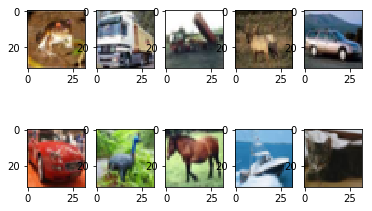

In [124]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow((x_train_norm * x_train_std + x_train_mean).astype(np.uint8)[i])
    
plt.show()

## Prepare LR CIFAR

In [92]:
x_train.shape

(50000, 32, 32, 3)

In [93]:
def images_resize(images, ratio):
    lr_width = images.shape[1] // ratio
    lr_height = images.shape[2] // ratio
    resized = np.zeros((images.shape[0], lr_width, lr_height, images.shape[3]))
    for i in tqdm(range(images.shape[0])):
        resized[i] = resize(images[i], (lr_width, lr_height))
        
    return resized

In [140]:
x_train_lr = images_resize(x_train, 2)
x_test_lr = images_resize(x_test, 2)

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 10000/10000 [00:09<00:00, 1080.26it/s]


In [139]:
x_train_lr.shape

(50000, 16, 16, 3)

In [141]:
x_train_lr_mean = np.mean(x_train_lr)
x_test_lr_mean = np.mean(x_test_lr)

x_train_lr_std = np.std(x_train_lr)
x_test_lr_std = np.std(x_test_lr)

In [142]:
x_train_lr_norm = (x_train_lr - x_train_lr_mean) / x_train_lr_std
x_test_lr_norm = (x_test_lr - x_test_lr_mean) / x_test_lr_std

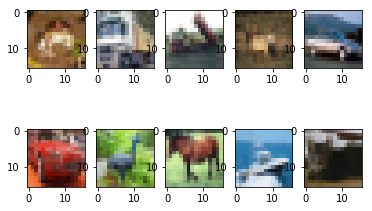

In [167]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(((x_train_lr_norm * x_train_lr_std + x_train_lr_mean) * 255).astype(np.uint8)[i])
    
plt.show()

## open_images_560_420 generator (or rather 420*560 ugh)

In [ ]:
def generator_images(path, size=(420, 560, 3), ratio=2, batch_size=32):
    lr_height, lr_width = size[0] // ratio, size[1] // ratio
    
    batch_i = 0
    batch = np.zeros((batch_size, size[0], size[1], size[2]))
    batch_scaled = np.zeros((batch_size, lr_height, lr_width, size[2]))
    
    while True:
        for file in os.listdir(path):
            if not file.endswith('.jpg'):
                continue 
            
            if batch_i == batch_size:
                yield batch_scaled, batch
                
                batch_i = 0
                batch = np.zeros((batch_size, size[0], size[1], size[2]))
                batch_scaled = np.zeros((batch_size, lr_height, lr_width, size[2]))
            
            file_path = path + file
            img = img_as_float(Image.open(file_path))
            if len(img.shape) == 2: 
                 img = np.asarray(np.dstack((img, img, img))) 
            
            batch[batch_i] = img
            batch_scaled[batch_i] = resize(img, (lr_height, lr_width))
            
            batch_i += 1

In [ ]:
def count_images(path):
    return sum([1 for file in os.listdir(path) if file.endswith('.jpg')])

In [ ]:
count_images(path_open_images_560_420_train), count_images(path_open_images_560_420_val)

# Network description 

![](srgan_architecture.png)

# Network implementation 

## Generator network

1. Input - Image LR
2. Conv, kernel 3x3, 64 feature maps, what's s1?
3. ParametricReLU
4. B=16 residual blocks
    1. Conv with 3x3 kernel, 64 feature maps and stride 1
    2. Batch Normalization (https://keras.io/layers/normalization/)
    3. ParametricReLU
    4. Conv with 3x3 kernel, 64 feature maps and stride 1
    5. Batch Normalization
    6. Elementwise sum (https://keras.io/layers/merge/ add)
5. Conv with 3x3 kernel, 64 feature maps and stride 1
6. Batch Normalization
7. Elementwise sum (https://keras.io/layers/merge/ add)
8. Shuffle block x2 (? how it's called ?)
    1. Conv with 3x3 kernel, 256 feature maps and stride 1
    2. PixelShuffler x2 https://gist.github.com/t-ae/6e1016cc188104d123676ccef3264981
    3. ParametricReLU
9. Conv with 9x9 kernel, 3 feature maps and stride 1
10. Estimated SR (super-resolved) image

Is the padding `same` a correct one? Otherwise the dims are not the same
Is the number of pixel shufflers the scaling ratio? 

In [279]:
# from https://gist.github.com/t-ae/6e1016cc188104d123676ccef3264981

class PixelShuffler(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')

    def call(self, inputs):

        input_shape = K.int_shape(inputs)
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))

        if self.data_format == 'channels_first':
            batch_size, c, h, w = input_shape
            if batch_size is None:
                batch_size = -1
            rh, rw = self.size
            oh, ow = h * rh, w * rw
            oc = c // (rh * rw)

            out = K.reshape(inputs, (batch_size, rh, rw, oc, h, w))
            out = K.permute_dimensions(out, (0, 3, 4, 1, 5, 2))
            out = K.reshape(out, (batch_size, oc, oh, ow))
            return out

        elif self.data_format == 'channels_last':
            batch_size, h, w, c = input_shape
            if batch_size is None:
                batch_size = -1
            rh, rw = self.size
            oh, ow = h * rh, w * rw
            oc = c // (rh * rw)

            out = K.reshape(inputs, (batch_size, h, w, rh, rw, oc))
            out = K.permute_dimensions(out, (0, 1, 3, 2, 4, 5))
            out = K.reshape(out, (batch_size, oh, ow, oc))
            return out

    def compute_output_shape(self, input_shape):

        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))

        if self.data_format == 'channels_first':
            height = input_shape[2] * self.size[0] if input_shape[2] is not None else None
            width = input_shape[3] * self.size[1] if input_shape[3] is not None else None
            channels = input_shape[1] // self.size[0] // self.size[1]

            if channels * self.size[0] * self.size[1] != input_shape[1]:
                raise ValueError('channels of input and size are incompatible')

            return (input_shape[0],
                    channels,
                    height,
                    width)

        elif self.data_format == 'channels_last':
            height = input_shape[1] * self.size[0] if input_shape[1] is not None else None
            width = input_shape[2] * self.size[1] if input_shape[2] is not None else None
            channels = input_shape[3] // self.size[0] // self.size[1]

            if channels * self.size[0] * self.size[1] != input_shape[3]:
                raise ValueError('channels of input and size are incompatible')

            return (input_shape[0],
                    height,
                    width,
                    channels)

    def get_config(self):
        config = {'size': self.size,
                  'data_format': self.data_format}
        base_config = super(PixelShuffler, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

In [361]:
def srgan_generator(input_shape, input_=None):
    kernel_size = (3, 3)
    kernel_size_last = (9, 9)
    features = 64
    features_shuffle = 256
    features_last = 3
    B = 16

    # 1, 2, 3
    input_1 = input_ if input_ is not None else Input(shape=input_shape)
    conv2d_2 = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same', 
                      name='generator_conv2d_2')(input_1)
    prelu_3 = PReLU(name='generator_prelu_3')(conv2d_2)

    # 4 - residual blocks
    last_layer = prelu_3
    for i in range(B):
        conv2d_4_A = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same', 
                            name='generator_conv2d_4_A_%s' % i)(last_layer)
        bn_4_B = BatchNormalization(name='generator_bn_4_B_%s' % i)(conv2d_4_A)
        prelu_4_C = PReLU(name='generator_prelu_4_C_%s' % i)(bn_4_B)
        conv2d_4_D = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same', 
                            name='generator_conv2d_4_D_%s' % i)(prelu_4_C)
        bn_4_E = BatchNormalization(name='generator_bn_4_E_%s' % i)(conv2d_4_D)
        add_4_F = Add(name='generator_add_4_F_%s' % i)([last_layer, bn_4_E])

        last_layer = add_4_F

    # 5, 6, 7
    conv2d_5 = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same', 
                      name='generator_conv2d_5')(last_layer)
    bn_6 = BatchNormalization(name='generator_bn_6')(conv2d_5)
    add_7 = Add(name='generator_add_7')([prelu_3, bn_6])

    # 8 - shuffle block
    last_layer = add_7
    for i in range(1):
        conv2d_8_A = Conv2D(filters=features_shuffle, kernel_size=kernel_size, strides=(1, 1), padding='same', 
                            name='generator_conv2d_8_A_%s' % i)(last_layer)
        shuffler_8_B = PixelShuffler(name='generator_shuffler_8_B_%s' % i)(conv2d_8_A)
        prelu_8_C = PReLU(name='generator_prelu_8_C_%s' % i)(shuffler_8_B)

        last_layer = prelu_8_C

    # 9 
    conv2d_9 = Conv2D(filters=features_last, kernel_size=kernel_size_last, strides=(1, 1), 
                      padding='same', activation='tanh', name='generator_conv2d_9')(last_layer)

    return Model(input_1, conv2d_9)

### Train generator

In [281]:
model_generator = srgan_generator((x_train_lr.shape[1], x_train_lr.shape[2], x_train_lr.shape[3]))
# model_generator = srgan_generator((210, 280, 3))
model_generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [282]:
model_generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_31 (InputLayer)            (None, 16, 16, 3)     0                                            
____________________________________________________________________________________________________
generator_conv2d_2 (Conv2D)      (None, 16, 16, 64)    1792        input_31[0][0]                   
____________________________________________________________________________________________________
generator_prelu_3 (PReLU)        (None, 16, 16, 64)    16384       generator_conv2d_2[0][0]         
____________________________________________________________________________________________________
generator_conv2d_4_A_0 (Conv2D)  (None, 16, 16, 64)    36928       generator_prelu_3[0][0]          
___________________________________________________________________________________________

In [283]:
train_version = 5

In [284]:
checkpointer = ModelCheckpoint(filepath='data/srgan_generator_weights_%s.{epoch:03d}_{val_acc:.4f}.hdf5' % train_version, 
                               verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='data/tensorboard/', histogram_freq=0, write_graph=True, write_images=True)

In [285]:
model_generator.fit(x_train_lr_norm, x_train_norm, epochs=1, validation_data=(x_test_lr_norm, x_test_norm), 
                    callbacks=[tb_callback])

# batch_size = 1
# n_train = 30 # count_images(path_open_images_560_420_train)
# n_val = 3 # count_images(path_open_images_560_420_val)
# with tf.device('/gpu:0'):
#     model_generator.fit_generator(generator_images(path_open_images_560_420_train, batch_size=batch_size), 
#                                   steps_per_epoch=n_train // batch_size,
#                                   validation_data=generator_images(path_open_images_560_420_val, 
#                                                                    batch_size=batch_size),
#                                   validation_steps=n_val // batch_size, epochs=1, callbacks=[tb_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 251s - loss: 0.1487 - acc: 0.8075 - val_loss: 0.1362 - val_acc: 0.8461


In [286]:
model_generator.save('data/srgan_generator_%s.model' % train_version)

In [150]:
model_generator.load_weights('data/srgan_generator_%s.model' % train_version)

In [ ]:
for g, type_ in [(generator_images(path_open_images_560_420_train, batch_size=1), 'train'), 
                 (generator_images(path_open_images_560_420_val, batch_size=batch_size), 'test')]:
    plt.figure(type_, figsize=(15, 30))
    for i, (x_lr, x) in enumerate(g):
        x_lr_ = (x_lr[0] * 255).astype(np.uint8)
        x_ = (x[0] * 255).astype(np.uint8)

        plt.subplot(10, 3, (i * 3) + 1)
        plt.imshow(x_lr_)

        plt.subplot(10, 3, (i * 3) + 2)
        plt.imshow(x_)

        plt.subplot(10, 3, (i * 3) + 3)
        plt.imshow((model_generator.predict(x_lr)[0] * 255).astype(np.uint8))

        if i >= 9:
            break
            
    plt.savefig('data/srgan_generator_%s_%s.png' % (train_version, type_))
    plt.show()

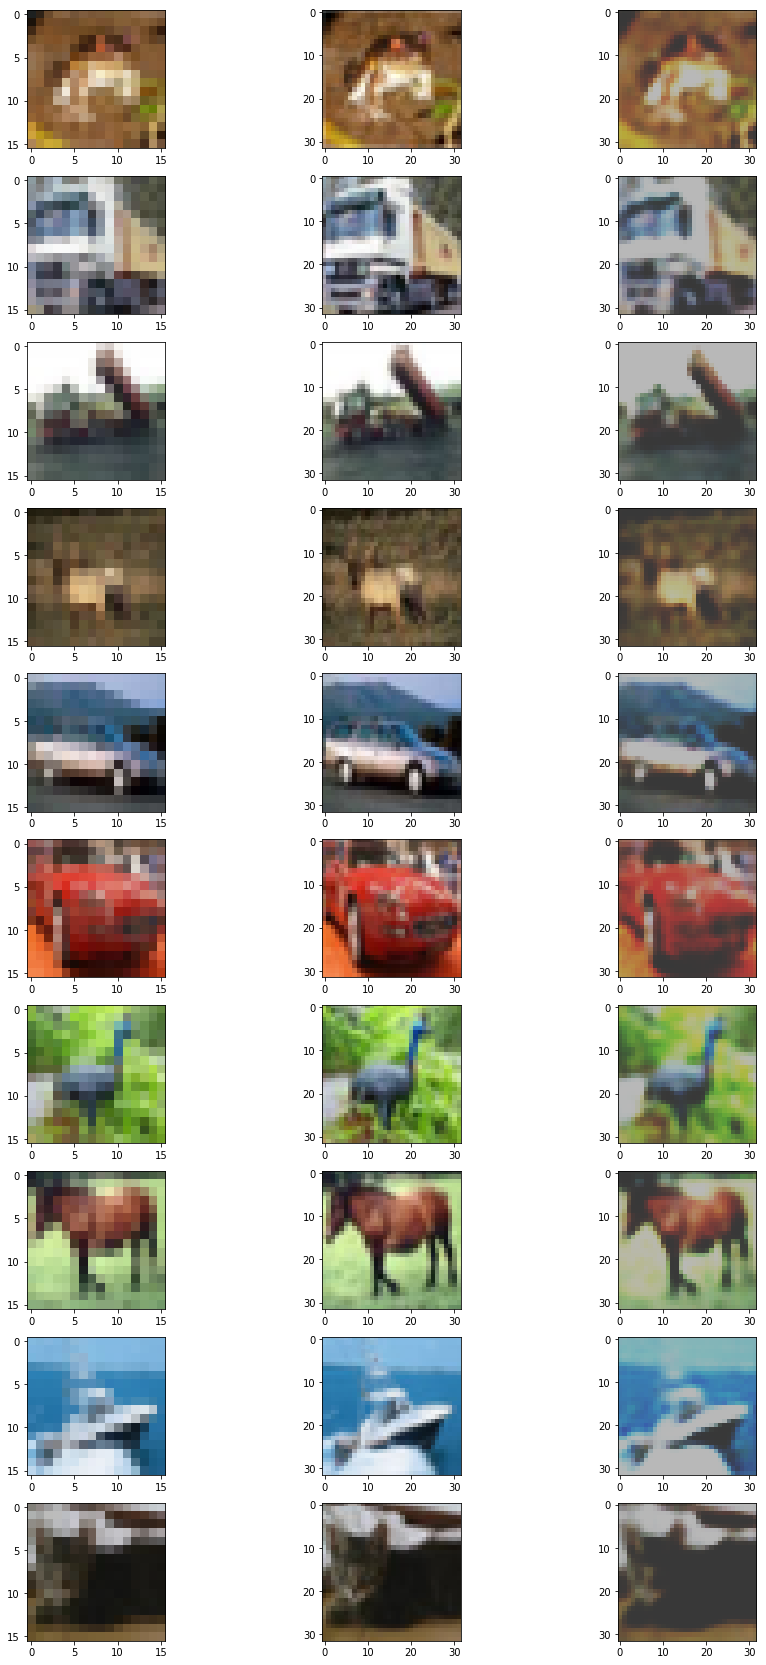

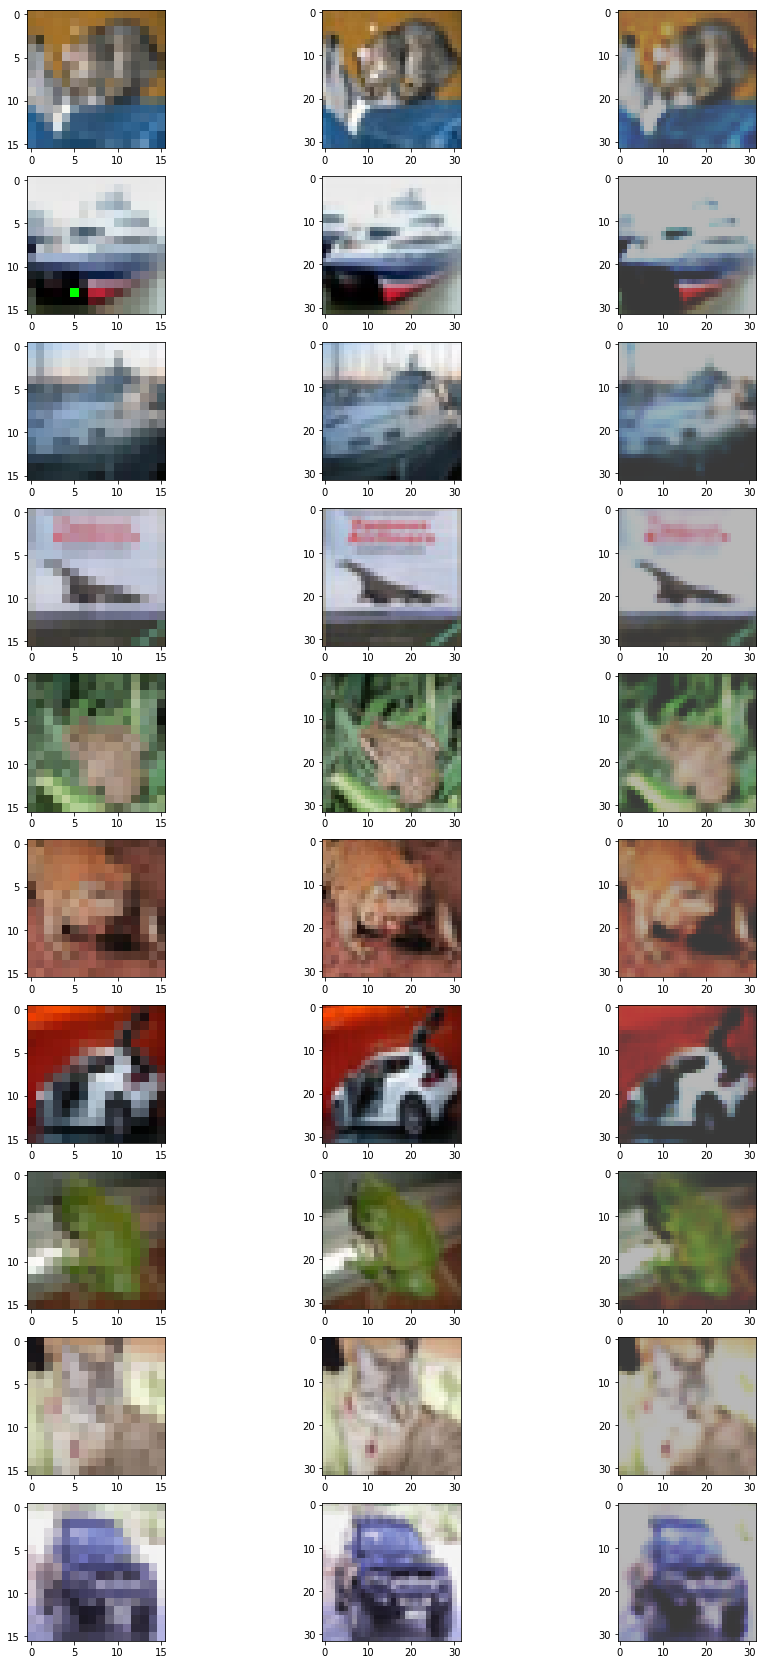

In [287]:
for x, x_lr, type_ in [(x_train, x_train_lr_norm, 'train'), (x_test, x_test_lr_norm, 'test')]:
    plt.figure(figsize=(15, 30))
    for i in range(10):
        plt.subplot(10, 3, (i * 3) + 1)
        plt.imshow(((x_lr[i] * x_train_lr_std + x_train_lr_mean) * 255).astype(np.uint8))

        plt.subplot(10, 3, (i * 3) + 2)
        plt.imshow(x[i])

        plt.subplot(10, 3, (i * 3) + 3)
        h, w = x_lr.shape[1], x_lr.shape[2]
        prediction = model_generator.predict(x_lr[i].reshape(1, h, w, 3))[0]
        plt.imshow((prediction * x_train_std + x_train_mean).astype(np.uint8))

    plt.savefig('data/srgan_generator_%s_%s.png' % (train_version, type_))
    plt.show()

In [ ]:
plt.figure(figsize=(15, 30))
for i in range(10):
    plt.subplot(10, 3, (i * 3) + 1)
    plt.imshow(x_test_lr[i])

    plt.subplot(10, 3, (i * 3) + 2)
    plt.imshow(x_test[i])

    plt.subplot(10, 3, (i * 3) + 3)
    w, h = x_test_lr.shape[1], x_test_lr.shape[2]
    plt.imshow(np.abs(model_generator.predict(x_test_lr[i].reshape(1, w, h, 3))[0]))

plt.savefig('data/srgan_generator_%s_test.png' % train_version)
plt.show()

## Discriminator network 

1. Input image
2. Conv2d with 3x3 kernel, 64 filters, and 1 stride
3. Leaky ReLU (https://keras.io/layers/advanced-activations/#leakyrelu)
3. Conv2d block
    1. Conv2d with 3x3 kernel, 64 filters, and 1 stride
    2. Batch normalization
    3. Leaky ReLU (https://keras.io/layers/advanced-activations/#leakyrelu)
4. Repeat 4 with 128 filters x 2 
5. Repeat 4 with 256 filters x 2 
6. Repeat 4 with 512 filters x 2 
7. Dense layer with 1024
8. Leaky ReLU
9. Dense 1 binary
10. Sigmoid

In [360]:
def srgan_discriminator(input_=None):
    input_shape = 32, 32, 3
    features_1 = 64
    features_2, features_3, features_4 = 128, 256, 512
    kernel_size = 3, 3
    strides = 1, 1
    strides_2 = 2, 2
    
    input_1 = Input(shape=input_shape) if input_ is None else input_    
        
    conv2d_2 = Conv2D(filters=features_1, kernel_size=kernel_size, strides=strides, padding='same', 
                      name='discriminator_conv2d_2')(input_1)
    lrelu_3 = LeakyReLU(name='discriminator_lrelu_3')(conv2d_2)
    
    conv2d_4_A = Conv2D(filters=features_1, kernel_size=kernel_size, strides=strides_2, padding='same', 
                        name='discriminator_conv2d_4_A')(lrelu_3)
    conv2d_4_B = BatchNormalization(name='discriminator_conv2d_4_B')(conv2d_4_A)
    lrelu_4_c = LeakyReLU(name='discriminator_lrelu_4_c')(conv2d_4_B)

    i = 0
    last_layer = lrelu_4_c
    for _features in [features_2, features_3, features_4]:
        for j in range(2):
            conv2d_5_A = Conv2D(filters=_features, kernel_size=kernel_size, strides=(strides if j == 0 else strides_2), 
                                padding='same', name='discriminator_conv2d_5_A_%s' % i)(last_layer)
            conv2d_5_B = BatchNormalization(name='discriminator_conv2d_5_B_%s' % i)(conv2d_5_A)
            lrelu_5_C = LeakyReLU(name='discriminator_lrelu_5_C_%s' % i)(conv2d_5_B)
            
            last_layer = lrelu_5_C
            i += 1
    
    flatten_8 = Flatten(name='discriminator_flatten_8')(last_layer)
    dense_8 = Dense(1024, name='discriminator_dense_8')(flatten_8)
    lrelu_9 = LeakyReLU(name='discriminator_lrelu_9')(dense_8)
    dense_10 = Dense(1, activation='sigmoid', name='discriminator_dense_10')(lrelu_9)
    
    return Model(input_1, dense_10)

### Train discriminator

In [289]:
def discriminator_generator_cifar(model_generator, x, x_predictions, batch_size=64):        
    batch_size = batch_size // 2
    
    batch_i = 0
    batch = np.zeros((batch_size, 32, 32, 3))
    batch_predictions = np.zeros((batch_size, 32, 32, 3))
    
    while True:
        for i in range(x.shape[0]):
            if batch_i == batch_size:
                
                # TODO: use soft and noisy labels
                yield np.concatenate((batch, batch_predictions)), \
                    np.concatenate((np.ones(batch_size), np.zeros(batch_size)))
                
                batch_i = 0
                batch = np.zeros((batch_size, 32, 32, 3))
                batch_predictions = np.zeros((batch_size, 32, 32, 3))
            
            batch[batch_i] = x[i]
            batch_predictions[batch_i] = x_predictions[i]
            
            batch_i += 1

In [290]:
epochs = 5
batch_size = 64
train_version = 5

In [291]:
# generator_in = Input(shape=(16, 16, 3))

model_generator = srgan_generator((16, 16, 3)) #, input_=generator_in)
model_discriminator = srgan_discriminator()

# generator_out = model_generator(generator_in)

# discriminator_out = model_discriminator(generator_out)
# model_srgan = Model(generator_in, discriminator_out)

In [292]:
model_generator.compile(optimizer='adam', loss='mse')
model_discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# TODO try using softmax instead of sigmoid for categorical crossentropy
# model_srgan.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [293]:
model_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
discriminator_conv2d_2 (Conv (None, 32, 32, 64)        1792      
_________________________________________________________________
discriminator_lrelu_3 (Leaky (None, 32, 32, 64)        0         
_________________________________________________________________
discriminator_conv2d_4_A (Co (None, 16, 16, 64)        36928     
_________________________________________________________________
discriminator_conv2d_4_B (Ba (None, 16, 16, 64)        256       
_________________________________________________________________
discriminator_lrelu_4_c (Lea (None, 16, 16, 64)        0         
_________________________________________________________________
discriminator_conv2d_5_A_0 ( (None, 16, 16, 128)       73856     
__________

In [217]:
model_generator.load_weights('data/srgan_generator_%s.model' % train_version)

In [218]:
path_train_predictions = path_data + ('srgan_generator_%s_train_predictions.npy' % train_version)
path_test_predictions = path_data + ('srgan_generator_%s_test_predictions.npy' % train_version)

In [294]:
x_train_predictions = model_generator.predict(x_train_lr_norm)
x_test_predictions = model_generator.predict(x_test_lr_norm)

In [295]:
np.min(x_train_predictions), np.max(x_train_predictions)

(-1.0, 1.0)

In [ ]:
# TEMPORARY FIX OF GPU MEMORY LEAK ? 

np.save(path_train_predictions, x_train_predictions)
np.save(path_test_predictions, x_test_predictions)

In [ ]:
x_train_predictions = np.load(path_train_predictions)
x_test_predictions = np.load(path_test_predictions)

In [296]:
checkpointer = ModelCheckpoint(filepath='data/srgan_discriminator_weights_%s.{epoch:03d}_{val_acc:.4f}.hdf5' % 
                               train_version, verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='data/tensorboard/', histogram_freq=0, write_graph=True, write_images=True)

In [297]:
# model_generator.fit(x_train_lr, x_train, epochs=100, validation_data=(x_test_lr, x_test), callbacks=[tb_callback])

with tf.device('/gpu:0'):
    model_discriminator.fit_generator(discriminator_generator_cifar(model_generator, x_train_norm, x_train_predictions, 
                                                                    batch_size), 
                                      steps_per_epoch=x_train.shape[0] // (batch_size * 2), 
                                      validation_data=discriminator_generator_cifar(model_generator, 
                                                                                    x_test_norm, x_test_predictions, 
                                                                                    batch_size), 
                                      validation_steps=x_test.shape[0] // (batch_size * 2), epochs=epochs, 
                                      callbacks=[tb_callback, checkpointer])

Epoch 1/5
390/390 [==============================] - 42s - loss: 0.0024 - acc: 0.9985 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 2/5
390/390 [==============================] - 33s - loss: 1.3503e-07 - acc: 1.0000 - val_loss: 1.1058e-07 - val_acc: 1.0000
Epoch 3/5
390/390 [==============================] - 33s - loss: 3.0916e-07 - acc: 1.0000 - val_loss: 1.2350e-07 - val_acc: 1.0000
Epoch 4/5
390/390 [==============================] - 33s - loss: 1.2320e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 5/5
390/390 [==============================] - 33s - loss: 1.0962e-07 - acc: 1.0000 - val_loss: 1.1094e-07 - val_acc: 1.0000


In [298]:
model_discriminator.save('data/srgan_discriminator_%s.model' % train_version)

In [299]:
model_discriminator.predict(x_train_norm[2].reshape(1, 32, 32, 3))

array([[ 1.]], dtype=float32)

## Train full SRGAN

In [427]:
# https://github.com/titu1994/Super-Resolution-using-Generative-Adversarial-Networks/blob/master/models.py#L420
# What shall I do? 

# generator_in = Input(shape=(16, 16, 3))
# discriminator_in = Input(shape=(32, 32, 16, 3))

# model_generator = srgan_generator((16, 16, 3), input_=generator_in)
# model_discriminator = srgan_discriminator()

# generator_out = model_generator(generator_in)

# discriminator_out = model_discriminator(generator_out)
# model_srgan = Model(generator_in, discriminator_out)

generator_in = Input(shape=(16, 16, 3))
model_generator = srgan_generator((16, 16, 3), input_=generator_in)
model_discriminator = srgan_discriminator()

generator_out = model_generator(generator_in)
discriminator_out = model_discriminator(generator_out)
model_srgan = Model(generator_in, outputs=discriminator_out)

In [428]:
model_srgan.compile(optimizer=adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# model_generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_discriminator.compile(optimizer=adam(lr=0.00002), loss='binary_crossentropy', metrics=['accuracy'])

In [429]:
model_srgan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        (None, 16, 16, 3)         0         
_________________________________________________________________
model_71 (Model)             (None, 32, 32, 3)         1736195   
_________________________________________________________________
model_72 (Model)             (None, 1)                 6792001   
Total params: 8,528,196
Trainable params: 8,520,260
Non-trainable params: 7,936
_________________________________________________________________


In [440]:
batch_size = 256
train_version = 6

In [431]:
model_generator.load_weights(path_data + ('srgan_generator_%s.model' % train_version))
model_discriminator.load_weights(path_data + ('srgan_discriminator_%s.model' % train_version))

In [432]:
checkpointer = ModelCheckpoint(filepath='data/srgan_weights_%s.{epoch:03d}_{val_acc:.4f}.hdf5' % 
                               train_version, verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='data/tensorboard/', histogram_freq=0, write_graph=True, write_images=True)

In [433]:
# model_generator.fit(x_train_lr, x_train, epochs=100, validation_data=(x_test_lr, x_test), callbacks=[tb_callback])

# discriminative network should be online trained while training whole GAN as well, so that 
# it improves on differating the original vs superscaled

def set_trainable(model, key_word, value=True):
    layers_list = [layer for layer in model.layers if key_word in layer.name]
    for layer in layers_list:
        layer.trainable = value

metrics_names = model_discriminator.metrics_names
with tf.device('/gpu:0'):
    for _ in range(5):
        with tqdm(total=x_train_lr.shape[0] // batch_size) as progress:
            for batch_i in np.arange(0, x_train_lr.shape[0], batch_size):
                if batch_size + batch_i > x_train_lr.shape[0]:
                    continue

                x_train_batch = x_train_norm[batch_i:batch_i+batch_size]
                x_train_lr_batch = x_train_lr_norm[batch_i:batch_i+batch_size]

    #             set_trainable(model_generator, 'generator', True)
                set_trainable(model_discriminator, 'discriminator', False)

                metrics_srgan = model_srgan.train_on_batch(x_train_lr_batch, [1] * batch_size)
            
    #             set_trainable(model_generator, 'generator', False)
                set_trainable(model_discriminator, 'discriminator', True)

                x_train_predictions = model_generator.predict(x_train_lr_batch)
                metrics = model_discriminator.train_on_batch(np.concatenate([x_train_predictions, x_train_batch]), 
                                                             np.concatenate([[0] * batch_size, [1] * batch_size]))
                progress.set_description('Srgan: %s: %s; %s: %s; Discriminator: %s: %s; %s: %s' % 
                    (metrics_names[0], metrics_srgan[0], metrics_names[1], metrics_srgan[1], metrics_names[0], 
                     metrics[0], metrics_names[1], metrics[1]))
                progress.update()

#             print(model_srgan.evaluate(x_test_lr_norm, [1] * x_test_lr_norm.shape[0]))
#             print(model_generator.evaluate(x_test_lr_norm, x_test_norm))

Srgan: loss: 3.01986e-05; acc: 1.0; Discriminator: loss: 0.268304; acc: 0.970703: 100%|██████████| 195/195 [07:32<00:00,  2.08s/it]  
Srgan: loss: 1.46528e-05; acc: 1.0; Discriminator: loss: 0.0445941; acc: 0.994141: 100%|██████████| 195/195 [06:45<00:00,  2.08s/it] 
Srgan: loss: 1.19214e-06; acc: 1.0; Discriminator: loss: 0.00736157; acc: 0.996094: 100%|██████████| 195/195 [06:45<00:00,  2.08s/it]
Srgan: loss: 2.45404e-07; acc: 1.0; Discriminator: loss: 0.00285247; acc: 0.998047: 100%|██████████| 195/195 [06:45<00:00,  2.08s/it]
Srgan: loss: 1.74157e-07; acc: 1.0; Discriminator: loss: 0.00101093; acc: 1.0: 100%|██████████| 195/195 [06:45<00:00,  2.08s/it]     


In [376]:
print(model_srgan.evaluate(x_test_lr_norm, [1] * x_test_lr_norm.shape[0]))
print(model_generator.evaluate(x_test_lr_norm, x_test_norm))

 9984/10000 [============================>.] - ETA: 0s[7.0945211730957034, 0.52200000000000002]


RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [441]:
predictions = model_generator.predict(x_train_lr_norm[:1])

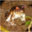

In [442]:
Image.fromarray(x_train[0])

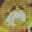

In [443]:
Image.fromarray((predictions[0] * x_train_std + x_train_mean).astype(np.uint8))

In [ ]:
print(model_discriminator.evaluate(x_test_lr_norm, x_test_norm))

In [379]:
preds_ = model_generator.predict(x_test_lr_norm)

In [380]:
preds_[0]

array([[[ 1.        , -1.        ,  1.        ],
        [ 1.        , -1.        ,  1.        ],
        [ 1.        , -1.        ,  1.        ],
        ..., 
        [ 1.        , -1.        ,  1.        ],
        [ 1.        , -0.99999982,  1.        ],
        [ 1.        , -0.99998558,  0.99992543]],

       [[ 1.        , -1.        ,  1.        ],
        [ 1.        , -1.        ,  1.        ],
        [ 1.        , -1.        ,  1.        ],
        ..., 
        [ 1.        , -1.        ,  0.99999994],
        [ 1.        , -1.        ,  1.        ],
        [ 1.        , -1.        ,  0.99835533]],

       [[ 1.        , -1.        ,  1.        ],
        [ 1.        , -1.        ,  1.        ],
        [ 1.        , -1.        ,  1.        ],
        ..., 
        [ 1.        , -1.        ,  0.99900037],
        [ 1.        , -1.        ,  0.99999994],
        [ 1.        , -1.        ,  0.67516661]],

       ..., 
       [[ 0.9999997 , -0.99999994,  0.99999928],
        

In [240]:
np.concatenate([x_train_predictions, x_train_batch]).shape

(128, 32, 32, 3)

In [54]:
np.min(x_train_batch)

0.0

In [118]:
_preds = model_generator.predict(x_lr[i].reshape(1, h, w, 3))[0]

np.min(x_train_predictions), np.max(x_train_predictions),\
np.min(x_train_batch), np.max(x_train_batch),\
np.min(x_train_lr_batch), np.max(x_train_lr_batch),\
np.min(x_train_lr), np.max(x_train_lr),\
np.min(x_test_lr), np.max(x_test_lr),\
np.min(x_train), np.max(x_train),\
np.min(x_test), np.max(x_test),\
np.min(x_lr[i].reshape(1, h, w, 3)), np.max(x_lr[i].reshape(1, h, w, 3)),\
np.min(_preds), np.max(_preds)

(0.0,
 1.0,
 0.0,
 1.0,
 0.000980392156862759,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.09901960784313732,
 0.9617647058823526,
 -8.477112,
 6.6625824)

In [75]:
_min = np.min(_preds)
_max = np.max(_preds)
_preds_0_1 = (_preds - _min) / (_max - _min)

In [76]:
_preds_0_1

array([[[0.6232563 , 0.64978236, 0.6261341 ],
        [0.6217619 , 0.63375324, 0.63152575],
        [0.6084329 , 0.6448013 , 0.62763214],
        ...,
        [0.42883524, 0.5152623 , 0.4629969 ],
        [0.59268624, 0.6264512 , 0.52053577],
        [0.58793217, 0.55099076, 0.44822115]],

       [[0.6344329 , 0.65796506, 0.63400173],
        [0.6368874 , 0.64659727, 0.61694753],
        [0.62222826, 0.6617577 , 0.635025  ],
        ...,
        [0.4441545 , 0.63368833, 0.5155614 ],
        [0.6677299 , 0.6535178 , 0.50627434],
        [0.5545663 , 0.7387596 , 0.5039221 ]],

       [[0.6431138 , 0.66564894, 0.63678443],
        [0.6502627 , 0.6516003 , 0.64547294],
        [0.62624484, 0.6643597 , 0.63395804],
        ...,
        [0.58045924, 0.4227419 , 0.35110953],
        [0.6725965 , 0.4416169 , 0.5622463 ],
        [0.630578  , 0.5962202 , 0.46292904]],

       ...,

       [[0.63692504, 0.62095946, 0.61705935],
        [0.64981455, 0.6108669 , 0.6030402 ],
        [0.640796  , 0

In [ ]:
print(model_srgan.evaluate(x_test_lr, [1] * x_test_lr.shape[0]))

In [445]:
model_srgan.save(path_data + ('srgan_%s.model' % train_version))
model_generator.save(path_data + ('srgan_final_generator_%s.model' % train_version))
model_discriminator.save(path_data + ('srgan_final_discriminator_%s.model' % train_version))

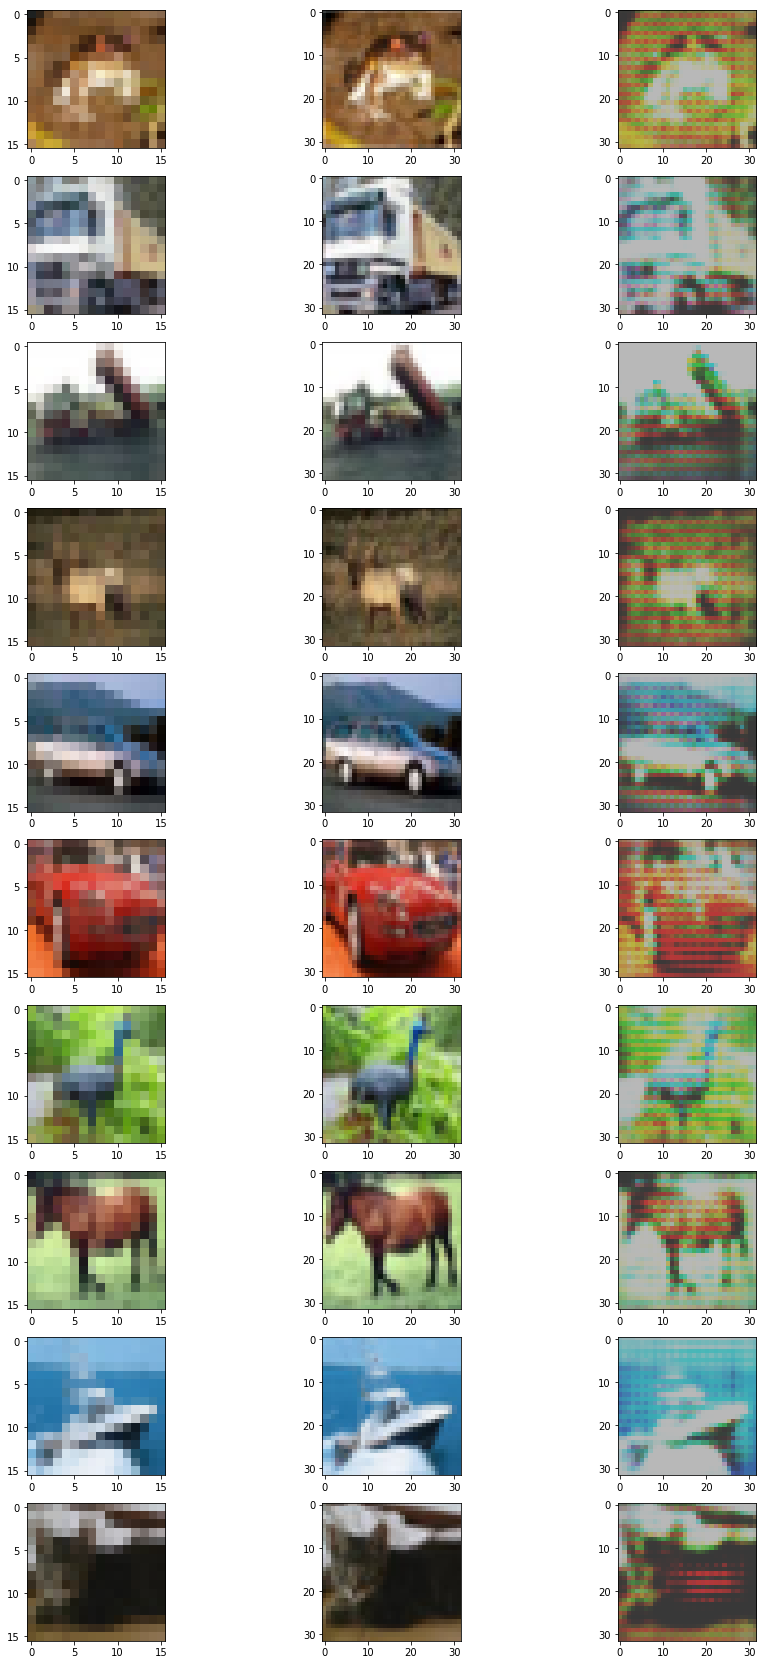

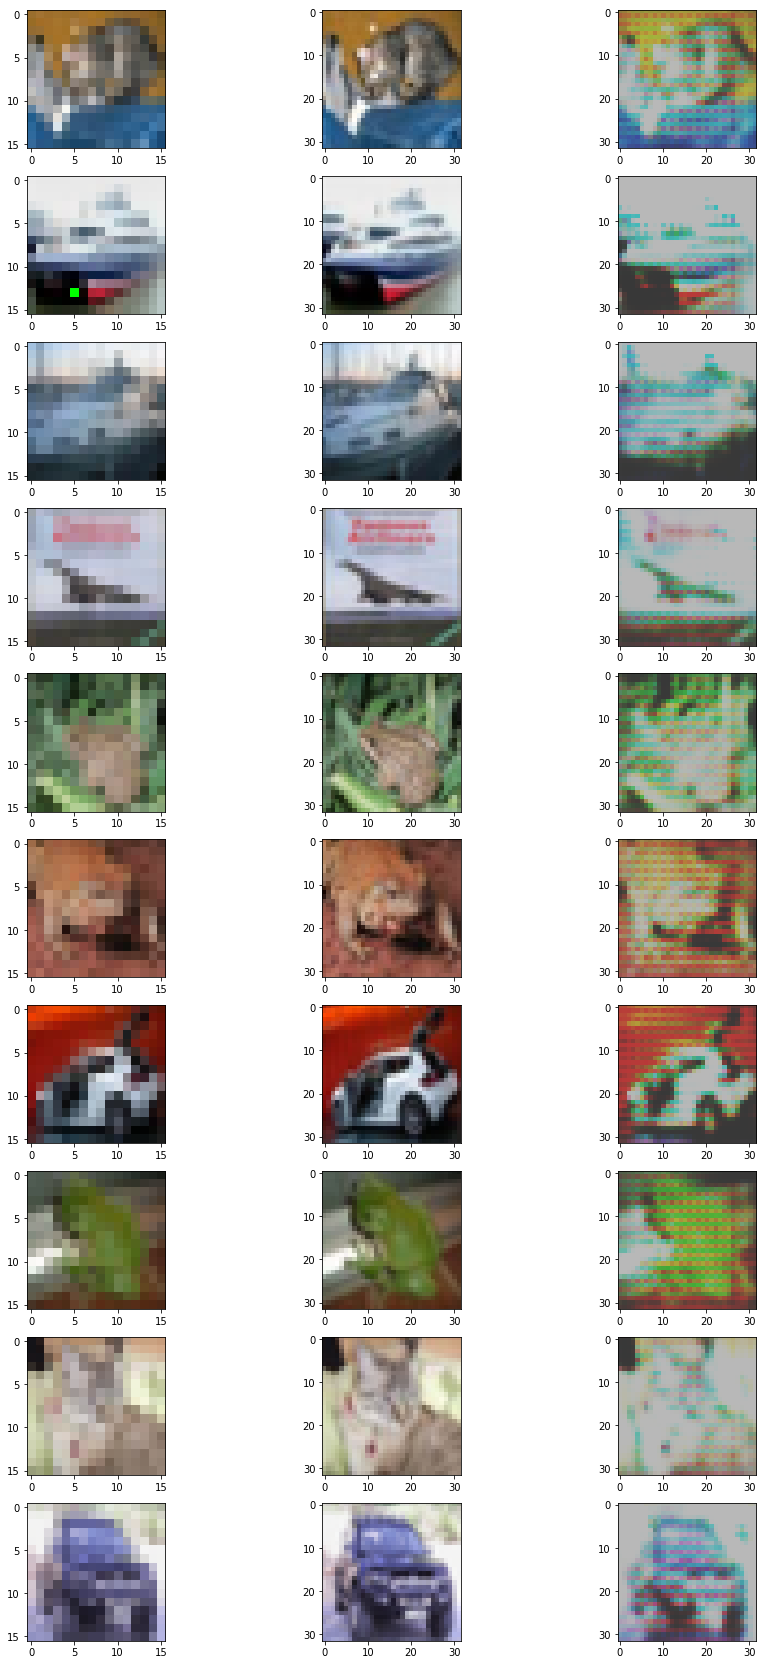

In [444]:
for x, x_lr, type_ in [(x_train, x_train_lr_norm, 'train'), (x_test, x_test_lr_norm, 'test')]:
    plt.figure(figsize=(15, 30))
    for i in range(10):
        plt.subplot(10, 3, (i * 3) + 1)
        plt.imshow(((x_lr[i] * x_train_lr_std + x_train_lr_mean) * 255).astype(np.uint8))

        plt.subplot(10, 3, (i * 3) + 2)
        plt.imshow(x[i])

        plt.subplot(10, 3, (i * 3) + 3)
        h, w = x_lr.shape[1], x_lr.shape[2]
        prediction = model_generator.predict(x_lr[i].reshape(1, h, w, 3))[0]
        plt.imshow((prediction * x_train_std + x_train_mean).astype(np.uint8))

    plt.savefig('data/srgan_generator_%s_%s.png' % (train_version, type_))
    plt.show()

# for x, x_lr, type_ in [(x_train, x_train_lr_norm, 'train'), (x_test, x_test_lr_norm, 'test')]:
#     plt.figure(figsize=(15, 30))
#     for i in range(10):
#         plt.subplot(10, 3, (i * 3) + 1)
#         plt.imshow(x_lr[i])

#         plt.subplot(10, 3, (i * 3) + 2)
#         plt.imshow(x[i])

#         plt.subplot(10, 3, (i * 3) + 3)
#         h, w = x_lr.shape[1], x_lr.shape[2]
#         prediction = model_generator.predict(x_lr[i].reshape(1, h, w, 3))[0]
#         plt.imshow((prediction * x_train_std + x_train_mean).astype(np.uint8))

#     plt.savefig('data/srgan_generator_%s_%s.png' % (train_version, type_))
#     plt.show()

In [439]:
# model_generator.fit(x_train_lr, x_train, epochs=100, validation_data=(x_test_lr, x_test), callbacks=[tb_callback])

# discriminative network should be online trained while training whole GAN as well, so that 
# it improves on differating the original vs superscaled

def set_trainable(model, key_word, value=True):
    layers_list = [layer for layer in model.layers if key_word in layer.name]
    for layer in layers_list:
        layer.trainable = value

metrics_names = model_discriminator.metrics_names
with tf.device('/gpu:0'):
    for _ in range(30):
        with tqdm(total=x_train_lr.shape[0] // batch_size) as progress:
            for batch_i in np.arange(0, x_train_lr.shape[0], batch_size):
                if batch_size + batch_i > x_train_lr.shape[0]:
                    continue

                x_train_batch = x_train_norm[batch_i:batch_i+batch_size]
                x_train_lr_batch = x_train_lr_norm[batch_i:batch_i+batch_size]

    #             set_trainable(model_generator, 'generator', True)
                set_trainable(model_discriminator, 'discriminator', False)

                metrics_srgan = model_srgan.train_on_batch(x_train_lr_batch, [1] * batch_size)
            
    #             set_trainable(model_generator, 'generator', False)
                set_trainable(model_discriminator, 'discriminator', True)

                x_train_predictions = model_generator.predict(x_train_lr_batch)
                metrics = model_discriminator.train_on_batch(np.concatenate([x_train_predictions, x_train_batch]), 
                                                             np.concatenate([[0] * batch_size, [1] * batch_size]))
                progress.set_description('Srgan: %s: %s; %s: %s; Discriminator: %s: %s; %s: %s' % 
                    (metrics_names[0], metrics_srgan[0], metrics_names[1], metrics_srgan[1], metrics_names[0], 
                     metrics[0], metrics_names[1], metrics[1]))
                progress.update()

#             print(model_srgan.evaluate(x_test_lr_norm, [1] * x_test_lr_norm.shape[0]))
#             print(model_generator.evaluate(x_test_lr_norm, x_test_norm))

Srgan: loss: 1.48546e-07; acc: 1.0; Discriminator: loss: 0.00114762; acc: 1.0: 100%|██████████| 195/195 [06:43<00:00,  2.08s/it]     
Srgan: loss: 1.49477e-07; acc: 1.0; Discriminator: loss: 0.00210896; acc: 0.998047: 100%|██████████| 195/195 [06:45<00:00,  2.08s/it]
Srgan: loss: 1.67173e-07; acc: 1.0; Discriminator: loss: 0.000835782; acc: 1.0: 100%|██████████| 195/195 [06:45<00:00,  2.08s/it]    
Srgan: loss: 1.28523e-07; acc: 1.0; Discriminator: loss: 0.00151611; acc: 1.0: 100%|██████████| 195/195 [06:45<00:00,  2.08s/it]     
Srgan: loss: 1.25263e-07; acc: 1.0; Discriminator: loss: 0.000977572; acc: 1.0: 100%|██████████| 195/195 [06:45<00:00,  2.08s/it]    
Srgan: loss: 1.23866e-07; acc: 1.0; Discriminator: loss: 0.000354231; acc: 1.0: 100%|██████████| 195/195 [06:45<00:00,  2.07s/it]    
Srgan: loss: 1.27126e-07; acc: 1.0; Discriminator: loss: 0.000137698; acc: 1.0: 100%|██████████| 195/195 [06:45<00:00,  2.09s/it]    
Srgan: loss: 1.27591e-07; acc: 1.0; Discriminator: loss: 7.870

In [67]:
np.min(model_generator.predict(x_lr[i].reshape(1, h, w, 3)))

-9.89642

In [82]:
model_srgan.predict(np.zeros((1, 16, 16, 3)))

array([[1.]], dtype=float32)

In [ ]:
Image.fromarray(model_generator.predict(x_lr[i].reshape(1, h, w, 3)).astype(np.uint8)[0])

In [35]:
x_lr[0]

array([[[0.60784314, 0.43627451, 0.18333333],
        [0.64313725, 0.45490196, 0.20098039],
        [0.6254902 , 0.4372549 , 0.1754902 ],
        [0.63431373, 0.45      , 0.18039216],
        [0.62352941, 0.44117647, 0.16568627],
        [0.62254902, 0.43921569, 0.18431373],
        [0.64705882, 0.45098039, 0.17941176],
        [0.66764706, 0.45882353, 0.15882353],
        [0.64509804, 0.44705882, 0.13823529],
        [0.6127451 , 0.44117647, 0.16960784],
        [0.57745098, 0.42156863, 0.19313725],
        [0.56764706, 0.40686275, 0.18431373],
        [0.57647059, 0.40686275, 0.1754902 ],
        [0.55686275, 0.38627451, 0.16372549],
        [0.54803922, 0.37745098, 0.13627451],
        [0.47647059, 0.34803922, 0.13235294]],

       [[0.6       , 0.42745098, 0.14901961],
        [0.64607843, 0.43431373, 0.15588235],
        [0.64411765, 0.43921569, 0.17156863],
        [0.65490196, 0.46372549, 0.18235294],
        [0.64215686, 0.45294118, 0.17156863],
        [0.65980392, 0.48235294,

In [46]:
x_train[0].reshape(1, 32, 32, 3).shape

(1, 32, 32, 3)

In [48]:
model_discriminator.predict(model_generator.predict(x_train_lr[0].reshape(1, 16, 16, 3)))

array([[1.]], dtype=float32)

In [ ]:
x_lr[i].reshape(1, h, w, 3)

In [ ]:
model_generator.predict(x_lr[i].reshape(1, h, w, 3).astype(np.uint8)).astype(np.uint8)[0]

In [ ]:
model_generator.predict(x_lr[0].reshape(1, h, w, 3))

In [ ]:
model_generator.predict(x_lr[0].reshape(1, h, w, 3)).astype(np.uint8)